In [9]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import matplotlib as mpl
from matplotlib.colors import LogNorm
from functools import partial

sys.path.append("../src/")
from tapm import utils

jax.config.update("jax_enable_x64", True)

In [35]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")
lambdaP = 2 / 360  # 1,2,4
betaSTI = 0.0016*5  # 0.0016 *[3, 5, 7]

## All the equations we need to calculate Nobs and Nreal as well as their derivatives with respect to H and P


In [36]:
def Nobs(P,H):
    #return lambdas(P,H) * Is(P,H) + lambdaa(P,H) * Ia(P,H)
    return (lambdas(P,H) * Is(P,H) + lambdaa(P,H) * Ia(P,H))/args["gammaT_STI"] # prevalence

def Nreal(P,H):
    #return betaSTI *((1-m(P,H))*(1-P) + P) * S(P,H) * (Ia(P,H) + Is(P,H)) + args['Sigma']
    return Ia(P,H) + Is(P,H) # prevalence


def S(P,H):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H)
    lambda_s_val = lambdas(P, H)
    lambda_a_val = lambdaa(P, H)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
    B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
    D = (tilde_gamma + mu) * (1 - psi) * Sigma

    discriminant = B**2 - 4 * A * D

    Ia_star = (-B - jnp.sqrt(discriminant)) / (2 * A)
    S_star = ((lambda_s_val + mu) * C * Ia_star - (1 - psi) * Sigma) / ((1 - psi) * kappa_val * (1 + C) * Ia_star)

    return S_star

def Ia(P,H):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H)
    lambda_s_val = lambdas(P, H)
    lambda_a_val = lambdaa(P, H)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
    B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
    D = (tilde_gamma + mu) * (1 - psi) * Sigma

    discriminant = B**2 - 4 * A * D

    Ia_star = (-B - jnp.sqrt(discriminant)) / (2 * A)

    return Ia_star

def Is(P,H):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H)
    lambda_s_val = lambdas(P, H)
    lambda_a_val = lambdaa(P, H)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
    B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
    D = (tilde_gamma + mu) * (1 - psi) * Sigma

    discriminant = B**2 - 4 * A * D

    Ia_star = (-B - jnp.sqrt(discriminant)) / (2 * A)
    Is_star = C * Ia_star

    return Is_star



def kappa(P, H):
    return betaSTI * (1 - m(P, H) * (1 - P))

def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)

def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P

def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H

def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))

def R0(P, H):
    return args["psi"] * (betaSTI * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (betaSTI * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])


In [37]:
dNobs_dP_jax =jax.grad(Nobs, argnums=0)
dNreal_dP_jax = jax.grad(Nreal, argnums=0)

## Calculations
Only for the lmabdaP and betaSTI from above. For Plot all different combos have to be run.

In [38]:
# compare gradients
Ps = np.linspace(0, 1, 101)
Hs = np.linspace(0, 0.2, 101)

dNobsdP = np.zeros((len(Hs), len(Ps)))
dNrealdP = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        dNobsdP[i, j] = dNobs_dP_jax(P, H)
        dNrealdP[i, j] = dNreal_dP_jax(P, H)

# compare Nobs and Nrea, not gradients
Nobs_vals = np.zeros((len(Hs), len(Ps)))
Nreal_vals = np.zeros((len(Hs), len(Ps)))
Nobs_Nreal_vals_comparison = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        Nobs_vals[i, j] = Nobs(P, H)
        Nreal_vals[i, j] = Nreal(P, H)
        Nobs_Nreal_vals_comparison[i, j] = Nobs_vals[i, j] - Nreal_vals[i, j]

# save stuff as npy files

with open(
    "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g_testprevalenceinsteadofincidence.npy"
    % (lambdaP * 360, betaSTI),
    "wb",
) as f:
    np.save(f, Ps)
    np.save(f, Hs)
    np.save(f, dNobsdP)
    np.save(f, dNrealdP)
    np.save(f, Nobs_vals)
    np.save(f, Nreal_vals)



## Final figure

/tmp/ipykernel_175552/3262505309.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


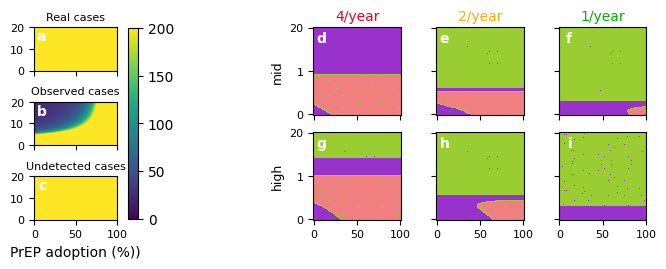

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors



# what we want to plot
Hs = np.linspace(0, 0.2, 201)
Ps = np.linspace(0, 1.0, 201)

lambda_P_values = [4 / 360.0, 2 / 360.0, 1 / 360.0]
lambda_P_labels = ["4/year", "2/year", "1/year"]
beta_STI_values = [0.0016 * 5.0, 0.0016 * 7.0]
beta_STI_labels = ["mid", "high"]
colors_stability = ["#E9002D", "#FFAA00", "#00B000"]

# Plot set-up
fig = plt.figure(figsize=(8.0, 2.5))
outer_grid = fig.add_gridspec(1, 2, width_ratios=[0.8, 2.5], wspace=0.7)

# Left side of the plot, Nobs, Nreal, Nreal-Nobs---------------------------------------------------------------------------------------------------
# set-up
left_grid = outer_grid[0].subgridspec(3, 1, hspace=0.7)
axs = []
for i in range(3):
    ax = fig.add_subplot(left_grid[i])
    axs.append(ax)
cmap = plt.get_cmap("viridis")
cmap.set_bad("#ABABAB")

# load data
with open("../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g_testprevalenceinsteadofincidence.npy" % (1, 0.008),"rb") as f:
    Ps_plot = np.load(f)
    Hs_plot = np.load(f)
    dNobsdP_plot = np.load(f)
    #dNobsdH_plot = np.load(f)
    dNrealdP_plot = np.load(f)
    #dNrealdH_plot = np.load(f)
    Nobs_plot = np.load(f) * 100000
    Nreal_plot = np.load(f) * 100000


Nreal_minus_Nobs_plot = Nreal_plot - Nobs_plot
threshold_setbad = 0.00003 * 100000
Nobs_plot[Nobs_plot < threshold_setbad] = np.nan
Nreal_plot[Nreal_plot < threshold_setbad] = np.nan
Nreal_minus_Nobs_plot[Nreal_minus_Nobs_plot < threshold_setbad] = np.nan
results = [Nreal_plot, Nobs_plot, Nreal_minus_Nobs_plot]
titles = ["Real cases", "Observed cases", "Undetected cases"]

# plotting
for i, ax in enumerate(axs):
    for color in colors_stability:
        cax = ax.imshow(results[i],origin="lower",vmin=0,vmax=200,cmap=cmap, aspect="auto")
        ax.set_title(titles[i], fontsize=8, pad=5)
    if i == 2:
        ax.set_xticks([0, 50, 100])#([0, 100, 200])
        ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        ax.set_xlabel("PrEP adoption (%))", fontsize=10)
    else:
        ax.set_xticks([0, 50, 100])#([0, 100, 200])
        ax.set_xticklabels([])
    ax.set_yticks([0, 50, 100])#([0, 100, 200])
    ax.set_yticklabels([int(Hs[0] * 100), int(Hs[100] * 100), int(Hs[200] * 100)], fontsize=8)
cbar = fig.colorbar(cax, ax=axs, shrink=0.99, pad=0.1)

# Add subpanel letters
for idx, ax in enumerate(axs):
    ax.text(0.15,0.95,chr(97 + idx),transform=ax.transAxes,fontsize=10,fontweight="bold",va="top",ha="right",color="white",)



# Second plot, signs of derivatives---------------------------------------------------------------------------------------------------

# set-up
cmap = mcolors.ListedColormap(["#ABABAB", 'orange', 'darkorchid', 'yellowgreen', 'lightcoral'])
bounds = [0, 1, 10, 100, 1000, 1001]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
right_grid = outer_grid[1].subgridspec(2, 3, wspace=0.2, hspace=0.2)
axes = []
for i in range(2):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(right_grid[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

# load data
results = [[], [], []]
for i, betaSTI in enumerate(beta_STI_values):
    res = []
    for lambdaP in lambda_P_values:
        with open( "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g_testprevalenceinsteadofincidence.npy" %(lambdaP * 360, betaSTI),"rb") as f:
            Ps_plot = np.load(f)
            Hs_plot = np.load(f)
            dNobsdP_plot = np.load(f)
            #dNobsdH_plot = np.load(f)
            dNrealdP_plot = np.load(f)
            #dNrealdH_plot = np.load(f)
            Nobs_plot = np.load(f) * 100000
            Nreal_plot = np.load(f) * 100000
        x = dNrealdP_plot * dNobsdP_plot
        real_positive_obs_negative = np.where((dNrealdP_plot > 0) & (dNobsdP_plot < 0), 1, 0)
        real_negative_obs_positive = np.where((dNrealdP_plot < 0) & (dNobsdP_plot > 0), 10, 0)
        both_positive = np.where((dNrealdP_plot > 0) & (dNobsdP_plot > 0), 100, 0)
        both_negative = np.where((dNrealdP_plot < 0) & (dNobsdP_plot < 0), 1000, 0)
        variable_to_plot = real_positive_obs_negative + real_negative_obs_positive + both_positive + both_negative
        res.append(variable_to_plot)
    results[i] = res

global_vmin = -1e-7
global_vmax = 1e-7

# plotting
for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        cax = ax.imshow(results[row_idx][col_idx],origin="lower",cmap=cmap,norm=norm)
        ax.set_xticks([0, 50, 100])#([0, 100, 200])
        ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        ax.set_yticks([0, 50, 100])#([0, 100, 200])
        ax.set_yticklabels([int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8)

        if row_idx == 0:
            ax.set_title(f"{label}", fontsize=10, pad=5, color=colors_stability[col_idx])
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)


        if row_idx == 1:
            ax.set_xticks([0, 50, 100])#([0, 100, 200])
            ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        else:
            ax.set_xticks([0, 50, 100])#([0, 100, 200])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, 50, 100])#([0, 100, 200])
            ax.set_yticklabels([int(Hs[0] * 100), int(Hs[10] * 100), int(Hs[200] * 100)], fontsize=8)
        else:
            ax.set_yticks([0, 50, 100])#([0, 100, 200])
            ax.set_yticklabels([])

# Add subpanel letters
for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(0.15,0.95,chr(97 + 3 + idx),transform=ax.transAxes,fontsize=10,fontweight="bold",va="top",ha="right",color="white",)

# Add colorbar
tick_locs = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
#cbar = fig.colorbar(cax,ax=[ax for row_axes in axes for ax in row_axes],shrink=0.9,pad=0.01,ticks=tick_locs,)
#cbar.ax.set_yticklabels(["both don't change", "real increase,\nobserved decrease", "real decrease,\nobserved increase", "both increase", "both decrease"], fontsize=9)

#fig.text(0.63, -0.05, "PrEP adoption (%)", ha="center", fontsize=10)
#fig.text(0.03,0.5,"Risk awareness (%)",va="center",rotation="vertical",fontsize=10)

plt.tight_layout()
plt.show()

fig.savefig("../figures/final_figure_withinflux_DERIVATIVES_testprevalenceinsteadofincidence.pdf", format="pdf", bbox_inches="tight")

## Archive

In [3]:
if False: # old model without influx, just didnt want to delete the equations yet

    # functions we need

    @partial(jax.jit, static_argnames=['H'])
    def Nobs(P, H): # corrected for influx
        return lambdas(P, H) * Is(P, H) + lambdaa(P, H) * Ia(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def Nreal(P, H): # corrected for influx
        return betaSTI * ((1 - m(P, H)) * (1 - P) + P) * S(P, H) * (Is(P, H) + Ia(P, H)) + args['Sigma']

    @partial(jax.jit, static_argnames=['H'])
    def Is(P, H):
        #if R0(P, H) < 1:
        #    return 0
        #else:
        return b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def Ia(P, H):
        #if R0(P, H) < 1:
        #    return 0
        #else:
        return ((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1)) / (
                -b(P, H) / args["psi"]
                + args["gamma_STI"]
                - args["gammaT_STI"]
                * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
            )

    @partial(jax.jit, static_argnames=['H'])
    def S(P, H):
        
        #if R0(P, H) < 1:
        #    return 1
        #else:
            #return a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H) + Is(P,H)) # no influx
            #return 1 / R0(P, H) # no influx
        return 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) # influx

    @partial(jax.jit, static_argnames=['H'])
    def lambdas(P, H):
        return args["lambda_s"] + lambdaa(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def lambdaa(P, H):
        return lambdaH(P, H) * (1 - P) + lambdaP * P

    @partial(jax.jit, static_argnames=['H'])
    def lambdaH(P, H):
        return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H

    @partial(jax.jit, static_argnames=['H'])
    def betaHIV(P, H):
        return args["beta_HIV"] * (1 - m(P, H))

    @partial(jax.jit, static_argnames=['H'])
    def m(P, H):
        return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))

    @partial(jax.jit, static_argnames=['H'])
    def a(P, H):
        return lambdas(P, H) + args["mu"]

    @partial(jax.jit, static_argnames=['H'])
    def b(P, H):
        return args["gamma_STI"] + lambdaa(P, H) + args["mu"]

    @partial(jax.jit, static_argnames=['H'])
    def R0(P, H):
        return args["psi"] * alpha(P, H) / b(P, H) + (1 - args["psi"]) * alpha(P, H) / a(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def alpha(P, H):
        return betaSTI * (1 - m(P, H) * (1 - P))

In [5]:
if False: # old model without influx, just didnt want to delete the equations yet
    

    # derivatives of functions
    # dx/dy names dx_dy for easier readability

    @partial(jax.jit, static_argnames=['H'])
    def dNobs_dP(P, H):
        #if R0(P, H) < 1:
        #    return 0
        #else:
        return (Is(P, H) * dlambdas_dP(P, H) + Ia(P, H) * dlambdaa_dP(P, H) + lambdas(P, H) * dIs_dP(P, H) + lambdaa(P, H) * dIa_dP(P, H))

    @partial(jax.jit, static_argnames=['H'])
    def dNobs_dH(P, H):
        #f R0(P, H) < 1:
        #    return 0
        #else:
        return (Is(P, H) * dlambdas_dH(P, H) + Ia(P, H) * dlambdaa_dH(P, H) + lambdas(P, H) * dIs_dH(P, H) + lambdaa(P, H) * dIa_dH(P, H))

    @partial(jax.jit, static_argnames=['H'])
    def dNreal_dP(P, H):
        #if R0(P, H) < 1:
        #    return 0
        #else:
        return betaSTI * S(P, H) * (((1 - m(P, H)) * (1 - P) + P) * (dIs_dP(P, H) + dIa_dP(P, H))+ (Is(P, H) + Ia(P, H)) * m(P, H)) + Nreal(P, H) / S(P, H) * dS_dP(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dNreal_dH(P, H):
        #if R0(P, H) < 1:
        #    return 0
        #else:
        return betaSTI * S(P, H) * (((1 - m(P, H)) * (1 - P) + P) * (dIs_dH(P, H) + dIa_dH(P, H))+ (Is(P, H) + Ia(P, H)) * ((1 - P) * (-dm_dH(P, H)))) + Nreal(P, H) / S(P, H) * dS_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dIs_dP(P, H):
        return (
            1 / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H) * db_dP(P, H)
            + b(P, H)
            * (1 - args["psi"])
            / args["psi"]
            * Ia(P, H)
            * (-1 / (a(P, H)) ** 2)
            * da_dP(P, H)
            + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * dIa_dP(P, H)
        )

    @partial(jax.jit, static_argnames=['H'])
    def dIs_dH(P, H):
        return (
            1 / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H) * db_dH(P, H)
            + b(P, H)
            * (1 - args["psi"])
            / args["psi"]
            * Ia(P, H)
            * (-1 / (a(P, H)) ** 2)
            * da_dH(P, H)
            + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * dIa_dH(P, H)
        )

    @partial(jax.jit, static_argnames=['H'])
    def dIa_dP(P, H):
        part1 = ((args["mu"] + args["gammaT_STI"])/ (-b(P, H) / args["psi"] + args["gamma_STI"]- args["gammaT_STI"]* (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"]))* (-1 / (R0(P, H))**2)* dR0_dP(P, H))
        part2 = (((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1))/ (-((b(P, H) / args["psi"]+ args["gamma_STI"]- args["gammaT_STI"]* (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"]))**2))* 
                (-1 / args["psi"] * db_dP(P, H)- args["gammaT_STI"]/ a(P, H)* (1 - args["psi"])/ args["psi"]* db_dP(P, H)+ args["gammaT_STI"]* b(P, H)/ (a(P, H))**2* (1 - args["psi"])/ args["psi"]* da_dP(P, H)))
        return part1 + part2

    @partial(jax.jit, static_argnames=['H'])
    def dIa_dH(P, H):
        part1 = (
            (args["mu"] + args["gammaT_STI"])
            / (
                -b(P, H) / args["psi"]
                + args["gamma_STI"]
                - args["gammaT_STI"]
                * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
            )
            * (-1 / (R0(P, H)) ** 2)
            * dR0_dH(P, H)
        )
        part2 = (((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1))/ (-((b(P, H) / args["psi"]+ args["gamma_STI"]- args["gammaT_STI"]* (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"]))** 2 ))
            * (-1 / args["psi"] * db_dH(P, H)- args["gammaT_STI"]/ a(P, H)* (1 - args["psi"])/ args["psi"]* db_dH(P, H)+ args["gammaT_STI"]* b(P, H)/ (a(P, H)) ** 2* (1 - args["psi"])/ args["psi"]* da_dH(P, H)))
        return part1 + part2

    @partial(jax.jit, static_argnames=['H'])
    def dS_dP(P, H):
        # without influx
        #part1 = (1/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)/ (Ia(P, H) + Is(P, H)) * da_dP(P, H))
        #part2 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* 1/ (Ia(P, H) + Is(P, H))* dIs_dP(P, H))
        #part3 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)* (-1 / (Ia(P, H) + Is(P, H)) ** 2)* (dIa_dP(P, H) + dIs_dP(P, H)))
        #part4 = (a(P, H)/ (-(1 - args["psi"]) * (alpha(P, H)) ** 2)* Is(P, H)/ (Ia(P, H) + Is(P, H))* dalpha_dP(P, H))

        # with influx
        part1 = -1/(alpha(P,H)**2 * (Ia(P,H)+Is(P,H))) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * dalpha_dP(P,H)
        part2 = -1/(alpha(P,H) * (Ia(P,H)+Is(P,H))**2) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * (dIa_dP(P,H) + dIs_dP(P,H))
        part3 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * Is(P,H)/(1-args['psi']) * dlambdas_dP(P,H)
        part4 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * (lambdas(P,H)+args['mu'])/(1-args['psi']) * dIs_dP(P,H)

        return part1 + part2 + part3 + part4

    @partial(jax.jit, static_argnames=['H'])
    def dS_dH(P, H):
        # without influx
        #part1 = (1/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)/ (Ia(P, H) + Is(P, H))* da_dH(P, H))
        #part2 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* 1/ (Ia(P, H) + Is(P, H)) * dIs_dH(P, H))
        #part3 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)* (-1 / (Ia(P, H) + Is(P, H)) ** 2)* (dIa_dH(P, H) + dIs_dH(P, H)))
        #part4 = (a(P, H)/ (-(1 - args["psi"]) * (alpha(P, H)) ** 2)* Is(P, H)/ (Ia(P, H) + Is(P, H))* dalpha_dH(P, H))

        # with influx
        part1 = -1/(alpha(P,H)**2 * (Ia(P,H)+Is(P,H))) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * dalpha_dH(P,H)
        part2 = -1/(alpha(P,H) * (Ia(P,H)+Is(P,H))**2) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * (dIa_dH(P,H) + dIs_dH(P,H))
        part3 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * Is(P,H)/(1-args['psi']) * dlambdas_dH(P,H)
        part4 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * (lambdas(P,H)+args['mu'])/(1-args['psi']) * dIs_dH(P,H)

        return part1 + part2 + part3 + part4

    @partial(jax.jit, static_argnames=['H'])
    def da_dP(P, H):
        return dlambdas_dP(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def da_dH(P, H):
        return dlambdas_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def db_dP(P, H):
        return dlambdaa_dP(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def db_dH(P, H):
        return dlambdaa_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dR0_dP(P, H):
        return (
            args["psi"] * alpha(P, H) * (-1 / (b(P, H)) ** 2) * db_dP(P, H)
            + (1 - args["psi"]) * alpha(P, H) * (-1 / (a(P, H)) ** 2) * da_dP(P, H)
            + (args["psi"] / b(P, H) + (1 - args["psi"]) / a(P, H)) * dalpha_dP(P, H)
        )

    @partial(jax.jit, static_argnames=['H'])
    def dR0_dH(P, H):
        return (
            args["psi"] * alpha(P, H) * (-1 / (b(P, H)) ** 2) * db_dH(P, H)
            + (1 - args["psi"]) * alpha(P, H) * (-1 / (a(P, H)) ** 2) * da_dH(P, H)
            + (args["psi"] / b(P, H) + (1 - args["psi"]) / a(P, H)) * dalpha_dH(P, H)
        )

    @partial(jax.jit, static_argnames=['H'])
    def dalpha_dP(P, H):
        return betaSTI * m(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dalpha_dH(P, H):
        return -betaSTI * (1 - P) * dm_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dlambdas_dP(P, H):
        return dlambdaa_dP(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dlambdas_dH(P, H):
        return dlambdaa_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dlambdaa_dP(P, H):
        return -lambdaH(P, H) + lambdaP

    @partial(jax.jit, static_argnames=['H'])
    def dlambdaa_dH(P, H):
        return (1 - P) * dlambdaH_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dlambdaH_dP(P, H):
        return 0

    @partial(jax.jit, static_argnames=['H'])
    def dlambdaH_dH(P, H):
        return args["c"] * (1 - m(P, H)) * args["beta_HIV"] - args["c"] * args["beta_HIV"] * H * dm_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dbetaHIV_dP(P, H):
        return 0

    @partial(jax.jit, static_argnames=['H'])
    def dbetaHIV_dH(P, H):
        return -args["beta_HIV"] * dm_dH(P, H)

    @partial(jax.jit, static_argnames=['H'])
    def dm_dP(P, H):
        return 0

    @partial(jax.jit, static_argnames=['H'])
    def dm_dH(P, H):
        return ((args["max_exp"] - args["min_exp"])/ args["tau_exp"] * np.exp(-H / args["tau_exp"]))